# Setup

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import urllib
from pathlib import Path
import tarfile
import re
from re import Pattern
from matplotlib import pyplot as plt
from email.message import EmailMessage
import nltk
from sklearn.model_selection import cross_val_score

from lib.email import EmailReader, load_email

nltk.download("punkt")

RANDOM_SEED = 42

sys.path.append(os.path.abspath("."))
np.random.seed(RANDOM_SEED)

[nltk_data] Downloading package punkt to /home/shane/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Fetch Data

In [2]:
# reusing from homl3 because I hate writing file extraction

def fetch_spam_data() -> list[Path]:
    spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
    ham_url = spam_root + "20030228_easy_ham.tar.bz2"
    spam_url = spam_root + "20030228_spam.tar.bz2"

    spam_path = Path() / "datasets" / "spam"
    spam_path.mkdir(parents=True, exist_ok=True)
    for dir_name, tar_name, url in (("easy_ham", "ham", ham_url),
                                    ("spam", "spam", spam_url)):
        if not (spam_path / dir_name).is_dir():
            path = (spam_path / tar_name).with_suffix(".tar.bz2")
            print("Downloading", path)
            urllib.request.urlretrieve(url, path)
            tar_bz2_file = tarfile.open(path)
            tar_bz2_file.extractall(path=spam_path)
            tar_bz2_file.close()
    return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]

In [3]:
ham_dir, spam_dir = fetch_spam_data()

In [4]:

FILE_NAME_PATTERN: Pattern = re.compile(r'^\d{5}\.[0-9a-f]{32}$')

def filter_files(pattern: Pattern, path: Path) -> list[Path]:
    return [f for f in sorted(path.iterdir()) if pattern.match(f.name)] # slightly more meaningful/reusable than original

ham_filenames: list[Path] = filter_files(FILE_NAME_PATTERN, ham_dir)
spam_filenames: list[Path] = filter_files(FILE_NAME_PATTERN, spam_dir)


# Sanity
assert len(spam_filenames) == 500
assert len(ham_filenames) == 2500

### Explore Email Data Format

In [5]:
tmp_test_email_ham = load_email(ham_filenames[0])
tmp_test_email_spam = load_email(spam_filenames[-2])

def print_content(email: EmailMessage):
    print(f"From: {email['From']}")
    print(f"Subject: {email['Subject']}")
    print(f"is_multipart: {email.is_multipart()}")
    print(f"Content: {email.get_content()}")

In [6]:
print_content(tmp_test_email_ham)

From: Robert Elz <kre@munnari.OZ.AU>
Subject: Re: New Sequences Window
is_multipart: False
Content:     Date:        Wed, 21 Aug 2002 10:54:46 -0500
    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>
    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>


  | I can't reproduce this error.

For me it is very repeatable... (like every time, without fail).

This is the debug log of the pick happening ...

18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}
18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury
18:19:04 Ftoc_PickMsgs {{1 hit}}
18:19:04 Marking 1 hits
18:19:04 tkerror: syntax error in expression "int ...

Note, if I run the pick command by hand ...

delta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury
1 hit

That's where the "1 hit" comes from (obviously).  The version of nmh I'm
using

In [7]:
print_content(tmp_test_email_spam)

From: eBayInternetMarketing@yahoo.com
Subject: Earn Your Fortune on eBay!
is_multipart: False
Content: <html>
<head>
</head>
  <body background="http://64.70.215.158/images//Gauze.jpg">
   
<div align="Center">  
<center>  
<table width="90%" bgcolor="#ffffff" border="0">
    <tbody>
    <tr>
      <td width="100%">                     
      <hr color="#0000ff">               
      <table width="100%" border="0">
          <tbody>
          <tr>
            <td width="100%" colspan="2"><font size="4" color="#0000FF"><b>The 
            Famous</b></font><b><font color="#0000ff" size="4">
            eBay Marketing e-Course...</font></b></td>
           </tr>
          <tr>
            <td valign="Top" align="Left" width="15%" height="90"><br>
                           
            <p> </p>
             </td>
            <td valign="Top" align="Left" width="85%">                  
       
            <center>               
            <p></p>
            </center>
             
     

### Convert into Pandas DataFrame

In [8]:
spam_emails: pd.DataFrame = EmailReader.read(spam_filenames)
ham_emails: pd.DataFrame = EmailReader.read(ham_filenames)

Now loading... '<bound method Path.absolute of PosixPath('datasets/spam/spam/00001.7848dde101aa985090474a91ec93fcf0')>'
Now loading... '<bound method Path.absolute of PosixPath('datasets/spam/spam/00002.d94f1b97e48ed3b553b3508d116e6a09')>'
Now loading... '<bound method Path.absolute of PosixPath('datasets/spam/spam/00003.2ee33bc6eacdb11f38d052c44819ba6c')>'
Now loading... '<bound method Path.absolute of PosixPath('datasets/spam/spam/00004.eac8de8d759b7e74154f142194282724')>'
Now loading... '<bound method Path.absolute of PosixPath('datasets/spam/spam/00005.57696a39d7d84318ce497886896bf90d')>'
Now loading... '<bound method Path.absolute of PosixPath('datasets/spam/spam/00006.5ab5620d3d7c6c0db76234556a16f6c1')>'
Now loading... '<bound method Path.absolute of PosixPath('datasets/spam/spam/00007.d8521faf753ff9ee989122f6816f87d7')>'
Now loading... '<bound method Path.absolute of PosixPath('datasets/spam/spam/00008.dfd941deb10f5eed78b1594b131c9266')>'
Now loading... '<bound method Path.absol

In [9]:
spam_emails

,subject,from_raw,from_name,from_email,from_uses_freemail,to_raw,to_names,to_emails,to_emails_count,reply_to_raw,...,html_body_stripped,plain_body,plain_body_stripped,content_types,non_main_content,multipart,char_count,word_count,shoutiness,exclamations
0,Life Insurance - Why Pay More?,12a1mailbot1@web.de,,12a1mailbot1@web.de,False,dcek1a1@netsgo.com,,dcek1a1@netsgo.com,1,None,...,Save up to 70% on Life Insurance.\nWhy Spend ...,None,None,"{""text/html"": 1}",0,False,3668,171,0.311475,4
1,[ILUG] Guaranteed to lose 10-12 lbs in 30 days...,Slim Down <taylor@s3.serveimage.com>,Slim Down,taylor@s3.serveimage.com,False,ilug@linux.ie,,ilug@linux.ie,1,None,...,None,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1) Fight The Risk of Cancer!\nhttp://www.adcli...,"{""text/plain"": 1}",0,False,781,73,0.380282,2
2,Guaranteed to lose 10-12 lbs in 30 days ...,Slim Down <sabrina@mx3.1premio.com>,Slim Down,sabrina@mx3.1premio.com,False,zzzz@spamassassin.taint.org,,zzzz@spamassassin.taint.org,1,None,...,None,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1) Fight The Risk of Cancer!\nhttp://www.adcli...,"{""text/plain"": 1}",0,False,636,62,0.404088,2
3,Re: Fw: User Name & Password to Membership To ...,Account Services <wsup@playful.com>,Account Services,wsup@playful.com,False,zzzz@spamassassin.taint.org,,zzzz@spamassassin.taint.org,1,None,...,None,##############################################...,##############################################...,"{""text/plain"": 1}",0,False,2915,382,0.465523,16
4,[ILUG-Social] re: Guaranteed to lose 10-12 lbs...,Slim n Trim <yenene@mx2.1premio.com>,Slim n Trim,yenene@mx2.1premio.com,False,social@linux.ie,,social@linux.ie,1,None,...,None,I thought you might like these:\n1) Slim Down ...,I thought you might like these:\n1) Slim Down ...,"{""text/plain"": 1}",0,False,659,64,0.342944,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,hurry,Rob <yelanotyami912@bot.or.th>,Rob,yelanotyami912@bot.or.th,False,yyyy@neteze.com,,yyyy@neteze.com,1,yelanotyami912@bot.or.th,...,Toy ABC's Good Morning America ranks it the #...,None,None,"{""text/html"": 1}",0,False,884,91,0.283835,5
496,Do you need a second MORTGAGE? ...,bolttish@hotmail.com,,bolttish@hotmail.com,True,webmaster@ehlaw.com,,webmaster@ehlaw.com,1,bolttish@hotmail.com,...,Untitled Document Let Mortgage Lenders compet...,None,None,"{""text/html"": 1}",0,False,2144,77,0.218062,0
497,,Mary's Store <removeme@marysstore.com>,Mary's Store,removeme@marysstore.com,False,yyyy@netnoteinc.com,,yyyy@netnoteinc.com,1,None,...,THANK YOU FOR SHOPPING WITH US GIFTS FOR ALL ...,None,None,"{""text/html"": 1}",0,True,2205,142,0.384519,0
498,Earn Your Fortune on eBay!,eBayInternetMarketing@yahoo.com,,eBayInternetMarketing@yahoo.com,True,webmaster@efi.ie,,webmaster@efi.ie,1,eBayInternetMarketing@yahoo.com,...,The Famous eBay Marketing e-Course... Learn T...,None,None,"{""text/html"": 1}",0,False,8826,678,0.280232,7


In [10]:
ham_emails

,subject,from_raw,from_name,from_email,from_uses_freemail,to_raw,to_names,to_emails,to_emails_count,reply_to_raw,...,html_body_stripped,plain_body,plain_body_stripped,content_types,non_main_content,multipart,char_count,word_count,shoutiness,exclamations
0,Re: New Sequences Window,Robert Elz <kre@munnari.OZ.AU>,Robert Elz,kre@munnari.OZ.AU,False,Chris Garrigues <cwg-dated-1030377287.06fa6d@D...,Chris Garrigues,cwg-dated-1030377287.06fa6d@DeepEddy.Com,1,None,...,None,"Date: Wed, 21 Aug 2002 10:54:46 -05...","Date: Wed, 21 Aug 2002 10:54:46 -0500 From: C...","{""text/plain"": 1}",0,False,1604,213,0.397756,0
1,[zzzzteana] RE: Alexander,Steve Burt <Steve_Burt@cursor-system.com>,Steve Burt,Steve_Burt@cursor-system.com,False,"""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoo...",'zzzzteana@yahoogroups.com',zzzzteana@yahoogroups.com,1,zzzzteana@yahoogroups.com,...,None,"Martin A posted:\nTassos Papadopoulos, the Gre...","Martin A posted:\nTassos Papadopoulos, the Gre...","{""text/plain"": 1}",0,False,899,103,0.409344,2
2,[zzzzteana] Moscow bomber,Tim Chapman <timc@2ubh.com>,Tim Chapman,timc@2ubh.com,False,zzzzteana <zzzzteana@yahoogroups.com>,zzzzteana,zzzzteana@yahoogroups.com,1,zzzzteana@yahoogroups.com,...,None,Man Threatens Explosion In Moscow \n\nThursday...,Man Threatens Explosion In Moscow Thursday Aug...,"{""text/plain"": 1}",0,False,1751,229,0.317533,2
3,[IRR] Klez: The Virus That Won't Die,Monty Solomon <monty@roscom.com>,Monty Solomon,monty@roscom.com,False,undisclosed-recipient:;,,,1,None,...,None,Klez: The Virus That Won't Die\n \nAlready the...,Klez: The Virus That Won't Die Already the mos...,"{""text/plain"": 1}",0,False,1127,159,0.305235,0
4,Re: [zzzzteana] Nothing like mama used to make,Stewart Smith <Stewart.Smith@ee.ed.ac.uk>,Stewart Smith,Stewart.Smith@ee.ed.ac.uk,False,zzzzteana@yahoogroups.com,,zzzzteana@yahoogroups.com,1,zzzzteana@yahoogroups.com,...,None,"> in adding cream to spaghetti carbonara, whi...","> in adding cream to spaghetti carbonara, whic...","{""text/plain"": 1}",0,False,1052,136,0.372624,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,[zzzzteana] Surfing the tube,Tim Chapman <timc@2ubh.com>,Tim Chapman,timc@2ubh.com,False,zzzzteana <zzzzteana@yahoogroups.com>,zzzzteana,zzzzteana@yahoogroups.com,1,zzzzteana@yahoogroups.com,...,None,Man killed 'trying to surf' on Tube train \nAn...,Man killed 'trying to surf' on Tube train Anan...,"{""text/plain"": 1}",0,False,1034,164,0.263056,1
2496,Re: [ILUG] Linux Install,Philip Trickett <phil@techworks.ie>,Philip Trickett,phil@techworks.ie,False,Gianni Ponzi <g.ponzi@epa.ie>,Gianni Ponzi,g.ponzi@epa.ie,1,None,...,None,"Hi Gianni,\n\nA very good resource for this is...","Hi Gianni, A very good resource for this is:\n...","{""text/plain"": 1}",0,False,1973,297,0.347187,0
2497,Re: [ILUG] Linux Install,Nick Murtagh <nickm@go2.ie>,Nick Murtagh,nickm@go2.ie,False,"""'ILUG@linux.ie'"" <ILUG@linux.ie>",'ILUG@linux.ie',ILUG@linux.ie,1,None,...,None,Gianni Ponzi wrote:\n> I have a prob when tryi...,Gianni Ponzi wrote:\n> I have a prob when tryi...,"{""text/plain"": 1}",0,False,397,56,0.292191,0
2498,[Spambayes] Re: New Application of SpamBayesia...,Michael Hudson <mwh@python.net>,Michael Hudson,mwh@python.net,False,spambayes@python.org,,spambayes@python.org,1,None,...,None,Neale Pickett <neale@woozle.org> writes:\n\n> ...,Neale Pickett <neale@woozle.org> writes: > Ski...,"{""text/plain"": 1}",0,False,965,141,0.319171,0


# Explore Data

some of the notable email body patterns

In [11]:
tmp_spam_content = spam_emails[["subject", "html_body_stripped", "plain_body_stripped"]]
tmp_ham_content = ham_emails[["subject", "html_body_stripped", "plain_body_stripped"]]

In [12]:
tmp_spam_content

,subject,html_body_stripped,plain_body_stripped
0,Life Insurance - Why Pay More?,Save up to 70% on Life Insurance.\nWhy Spend ...,None
1,[ILUG] Guaranteed to lose 10-12 lbs in 30 days...,None,1) Fight The Risk of Cancer!\nhttp://www.adcli...
2,Guaranteed to lose 10-12 lbs in 30 days ...,None,1) Fight The Risk of Cancer!\nhttp://www.adcli...
3,Re: Fw: User Name & Password to Membership To ...,None,##############################################...
4,[ILUG-Social] re: Guaranteed to lose 10-12 lbs...,None,I thought you might like these:\n1) Slim Down ...
...,...,...,...
495,hurry,Toy ABC's Good Morning America ranks it the #...,None
496,Do you need a second MORTGAGE? ...,Untitled Document Let Mortgage Lenders compet...,None
497,,THANK YOU FOR SHOPPING WITH US GIFTS FOR ALL ...,None
498,Earn Your Fortune on eBay!,The Famous eBay Marketing e-Course... Learn T...,None


In [13]:
tmp_ham_content

,subject,html_body_stripped,plain_body_stripped
0,Re: New Sequences Window,None,"Date: Wed, 21 Aug 2002 10:54:46 -0500 From: C..."
1,[zzzzteana] RE: Alexander,None,"Martin A posted:\nTassos Papadopoulos, the Gre..."
2,[zzzzteana] Moscow bomber,None,Man Threatens Explosion In Moscow Thursday Aug...
3,[IRR] Klez: The Virus That Won't Die,None,Klez: The Virus That Won't Die Already the mos...
4,Re: [zzzzteana] Nothing like mama used to make,None,"> in adding cream to spaghetti carbonara, whic..."
...,...,...,...
2495,[zzzzteana] Surfing the tube,None,Man killed 'trying to surf' on Tube train Anan...
2496,Re: [ILUG] Linux Install,None,"Hi Gianni, A very good resource for this is:\n..."
2497,Re: [ILUG] Linux Install,None,Gianni Ponzi wrote:\n> I have a prob when tryi...
2498,[Spambayes] Re: New Application of SpamBayesia...,None,Neale Pickett <neale@woozle.org> writes: > Ski...


In [14]:
from collections import defaultdict
from typing import Callable
from nltk.stem import PorterStemmer

#tmp_spam_body = tmp_spam_content.head(1)["html_body_stripped"].iloc[0]

RE_WHITESPACE = re.compile(r'\s+')
RE_PUNCTUATION = re.compile(r'[.!\'",-/\\]')
RE_ALLOWED_WORD = re.compile(r'^[a-zA-Z0-9]{1,50}$')

IGNORE_LIST = set([
    # "the",
    # "to",
    # "of",
    # "and",
    # "if",
    # "a",
    # "in",
    # "it",
    # "is",
    # "that",
    # "i",
    # "you",
    # "for",
    # "your",
    # "thi",
    # "be",
    # "with",
    # "or",
    # "are"
    # "from",
    # "not",
    # "on"
])

stemmer = PorterStemmer()

def loop_tokens(text: str, callback: Callable[[str], None]):
    text = RE_WHITESPACE.sub(" ", text)
    text = RE_PUNCTUATION.sub("", text)
    words = text.split(" ")

    for w in words:
        w_lower = w.lower()

        if RE_ALLOWED_WORD.match(w_lower) and w_lower not in IGNORE_LIST:
            callback(w_lower)


def extract_words(text: str, root_counter: defaultdict[str, int], whitelist: set[str] | None = None):

    def increment_counters(w_lower: str):
        nonlocal root_counter, whitelist

        root = stemmer.stem(w_lower)

        if root not in IGNORE_LIST and (whitelist is None or root in whitelist):
            root_counter[root] += 1

    loop_tokens(text, increment_counters)


def process_rows(df: pd.DataFrame) -> tuple[dict[str, int], dict[str, int]]:
    subject_counter = defaultdict(int)
    root_counter = defaultdict(int)

    for row in df.iloc:
        body_stripped = row["html_body_stripped"]
        #print(body_stripped)

        if body_stripped is not None:
            extract_words(body_stripped, root_counter)

        plain_stripped = row["plain_body_stripped"]
        if plain_stripped is not None:
            extract_words(plain_stripped, root_counter)

        subject = row["subject"]
        extract_words(subject, subject_counter)

    return (subject_counter, root_counter)


# Extract the data
spam_subj_counter, spam_body_counter = process_rows(spam_emails)
ham_subj_counter, ham_body_counter = process_rows(ham_emails)

In [15]:
# Root Body Count - SPAM

pd.DataFrame([[key, value] for key, value in spam_body_counter.items()], columns=["Word", "Count"]).sort_values(["Count"], ascending=False)

,Word,Count
30,the,5969
2,to,5138
24,and,3836
54,of,3676
10,you,3402
...,...,...
4777,decidedli,1
4778,wherebi,1
4779,devoid,1
4780,oversight,1


In [16]:
# Root Body Count - HAM

pd.DataFrame([[key, value] for key, value in ham_body_counter.items()], columns=["Word", "Count"]).sort_values(["Count"], ascending=False)

,Word,Count
21,the,22818
94,to,13098
24,of,10644
65,and,10433
88,a,10329
...,...,...
14092,hone,1
7277,devcdrom1,1
14090,spamassassinsight,1
14089,ummm,1


In [17]:
# Root Subject Count - SPAM

pd.DataFrame([[key, value] for key, value in spam_subj_counter.items()], columns=["Word", "Count"]).sort_values(["Count"], ascending=False)

,Word,Count
22,your,72
51,the,53
66,for,51
54,you,46
72,a,44
...,...,...
494,legal,1
496,seen,1
497,tv,1
498,cptj,1


In [18]:
# Root Subject Count - HAM

pd.DataFrame([[key, value] for key, value in ham_subj_counter.items()], columns=["Word", "Count"]).sort_values(["Count"], ascending=False)

,Word,Count
6,the,365
45,for,287
15,to,204
61,of,191
22,a,180
...,...,...
1776,o,1
1775,bunnyhugg,1
1774,gearhead,1
1773,mozilla,1


In [19]:
TOP_WORDS_LIMIT = 200

def get_top_words(counter: dict[str, int], top: int) -> list[tuple[str, int]]:
    top_spam_words = list(counter.items())
    top_spam_words.sort(key=lambda x: -x[1]) # by value

    return top_spam_words[:top]

def extract_top_words(counter: dict[str, int], top: int):
    return [w[0] for w in get_top_words(counter, top=top)]

top_spam_body_words = extract_top_words(spam_body_counter, top=TOP_WORDS_LIMIT)
top_ham_body_words = extract_top_words(ham_body_counter, top=TOP_WORDS_LIMIT)

In [20]:
top_spam_body_words

['the',
 'to',
 'and',
 'of',
 'you',
 'a',
 'for',
 'in',
 'your',
 'thi',
 'is',
 'that',
 'i',
 'it',
 'with',
 'be',
 'email',
 'or',
 'are',
 'on',
 'will',
 'have',
 'from',
 'not',
 'we',
 'as',
 'our',
 'if',
 'free',
 'by',
 'all',
 'do',
 'my',
 'can',
 'receiv',
 'no',
 'money',
 'pleas',
 'an',
 'more',
 'get',
 'list',
 'out',
 'order',
 'at',
 'make',
 'click',
 'busi',
 'mail',
 'here',
 'us',
 'inform',
 'remov',
 'ani',
 'wa',
 'one',
 'peopl',
 'send',
 'onli',
 'address',
 'time',
 'report',
 'name',
 'now',
 'just',
 'compani',
 'offer',
 'ha',
 'new',
 'use',
 'program',
 'day',
 'how',
 'who',
 'de',
 'me',
 'up',
 'so',
 'want',
 'year',
 'work',
 'over',
 'market',
 'need',
 'state',
 'go',
 'form',
 'servic',
 'their',
 'what',
 'home',
 'govern',
 'but',
 'grant',
 'about',
 'wish',
 'dont',
 'help',
 '1',
 'million',
 'other',
 'been',
 'internet',
 'also',
 'site',
 'there',
 'includ',
 'below',
 'messag',
 'price',
 'hi',
 'like',
 'right',
 'person',
 'wou

In [21]:
top_ham_body_words

['the',
 'to',
 'of',
 'and',
 'a',
 'in',
 'it',
 'is',
 'that',
 'i',
 'for',
 'on',
 'thi',
 'you',
 'be',
 'with',
 'have',
 'not',
 'as',
 'are',
 'but',
 'from',
 'at',
 'use',
 'or',
 'wa',
 'if',
 'an',
 'by',
 'they',
 'all',
 'can',
 'my',
 'ha',
 'we',
 'your',
 'so',
 'there',
 'will',
 'get',
 'do',
 'one',
 'list',
 'about',
 'just',
 'more',
 'what',
 'mail',
 'like',
 'would',
 'which',
 'their',
 'time',
 'other',
 'he',
 '2002',
 'messag',
 'out',
 'some',
 'work',
 'no',
 'peopl',
 'when',
 'up',
 'who',
 'dont',
 'new',
 'onli',
 'been',
 'ani',
 'than',
 'make',
 'me',
 'our',
 'now',
 'think',
 'im',
 'were',
 'then',
 'email',
 'them',
 'hi',
 'also',
 'had',
 'way',
 'file',
 'said',
 'into',
 'tri',
 'run',
 'want',
 'could',
 'how',
 'go',
 'say',
 'world',
 'look',
 'becaus',
 'need',
 'even',
 'year',
 'should',
 'group',
 'first',
 'know',
 'see',
 'problem',
 'chang',
 'state',
 'most',
 'here',
 'these',
 'us',
 'thing',
 'same',
 'spam',
 'good',
 'take'

Top SPAM words that are infrequent in HAM

In [22]:
MIN_SPAM_RATIO = 5.0
HAM_TO_SPAM_RATIO = len(ham_emails) / len(spam_emails)
MIN_REQUIRED_JUST_SPAM = 4
MIN_TOTAL_REQUIRED = 10

def extract_proportion(
        spam_counter: dict[str, int],
        ham_counter: dict[str, int],
        min_spam_ratio: float,
        ham_to_spam_ratio: float) -> tuple[pd.DataFrame, dict[str, tuple[int, int, float]]]:

    spam_infrequent_ham: dict[str, tuple[int, int, float]] = {}

    for word, count in spam_counter.items():

        # weighted count, because the # of spam messages != the # of ham messages
        ratio = (count * ham_to_spam_ratio) / max(1, ham_counter.get(word, 1))
        total = count + ham_counter.get(word, 0)

        if (count >= MIN_REQUIRED_JUST_SPAM or total >= MIN_TOTAL_REQUIRED) and ratio > min_spam_ratio:
            spam_infrequent_ham[word] = (count, ham_counter.get(word, 0), ratio)

    spam_ham_df = pd.DataFrame(
        [[key, value[2], value[0], value[1]] for key, value in spam_infrequent_ham.items()],
        columns=["Word", "Ratio", "Spam Count", "Ham Count"]
    ).sort_values(["Ratio"], ascending=False)

    return (spam_ham_df, spam_infrequent_ham)

In [23]:
spam_ham_body_df, spam_ham_body_compare = extract_proportion(
    spam_body_counter,
    ham_body_counter,
    min_spam_ratio=MIN_SPAM_RATIO,
    ham_to_spam_ratio=HAM_TO_SPAM_RATIO
)

spam_ham_body_df.style.bar(subset=["Ratio", "Spam Count", "Ham Count"])

,Word,Ratio,Spam Count,Ham Count
819,enenkio,610.000000,122,0
826,atol,455.000000,91,0
832,hermio,260.000000,52,0
820,kingdom,257.500000,103,2
574,ebook,245.000000,49,0
842,eneenkio,205.000000,41,0
286,featurepack,195.000000,39,0
644,cna,185.000000,37,1
946,sur,170.000000,34,0
559,annuiti,160.000000,32,0


In [24]:
spam_ham_subj_df, spam_ham_subj_compare = extract_proportion(
    spam_subj_counter,
    ham_subj_counter,
    min_spam_ratio=MIN_SPAM_RATIO,
    ham_to_spam_ratio=HAM_TO_SPAM_RATIO
)

spam_ham_subj_df.style.bar(subset=["Ratio", "Spam Count", "Ham Count"])

,Word,Ratio,Spam Count,Ham Count
51,money,75.000000,15,0
35,systemwork,70.000000,14,0
1,insur,60.000000,12,0
36,clearanc,55.000000,11,0
64,sale,50.000000,10,1
20,per,50.000000,10,0
40,mortgag,50.000000,10,1
15,home,47.500000,19,2
3,guarante,45.000000,9,0
16,rep,45.000000,9,0


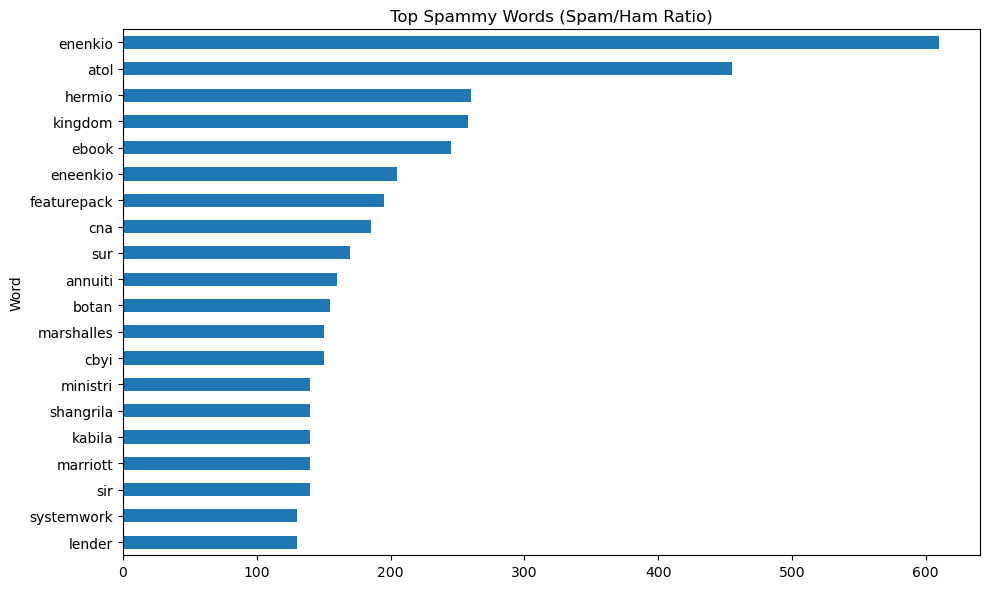

In [25]:
top = spam_ham_body_df.head(20)

top.plot.barh(x="Word", y="Ratio", figsize=(10, 6), legend=False, title="Top Spammy Words (Spam/Ham Ratio)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
RATIO_WORDS_LIMIT = 100

def get_most_frequent_spam_words(spam_infrequent_ham: dict[str, tuple[int, int, float]]) -> dict[str, float]:
    most_frequent_spam_words = [(word, counts[2]) for word, counts in spam_infrequent_ham.items()]
    most_frequent_spam_words.sort(key=lambda w: -w[1])
    cutoff_list = most_frequent_spam_words[:RATIO_WORDS_LIMIT]

    return {word: ratio for (word, ratio) in cutoff_list}

In [27]:
most_frequent_body_spam_words = get_most_frequent_spam_words(spam_ham_body_compare)
most_frequent_body_spam_words

{'enenkio': 610.0,
 'atol': 455.0,
 'hermio': 260.0,
 'kingdom': 257.5,
 'ebook': 245.0,
 'eneenkio': 205.0,
 'featurepack': 195.0,
 'cna': 185.0,
 'sur': 170.0,
 'annuiti': 160.0,
 'botan': 155.0,
 'cbyi': 150.0,
 'marshalles': 150.0,
 'kabila': 140.0,
 'sir': 140.0,
 'ministri': 140.0,
 'marriott': 140.0,
 'shangrila': 140.0,
 'systemwork': 130.0,
 'nonsmok': 130.0,
 'lender': 130.0,
 'optout': 125.0,
 'unwant': 125.0,
 'tollfre': 125.0,
 'zowi': 125.0,
 'wowi': 125.0,
 'majesti': 120.0,
 'ou': 120.0,
 'lb': 115.0,
 'jodi': 115.0,
 'au': 115.0,
 'smoker': 110.0,
 'ratak': 110.0,
 'savoir': 110.0,
 'specialist': 105.0,
 'tobacco': 105.0,
 'rmi': 105.0,
 'iroijlaplap': 105.0,
 'murjel': 105.0,
 'congo': 100.0,
 'laurent': 100.0,
 'diabet': 100.0,
 'monarch': 100.0,
 'entrepris': 100.0,
 'mladih': 100.0,
 'postal': 95.0,
 'mortgag': 95.0,
 'remio': 95.0,
 'herba': 95.0,
 'optin': 93.33333333333333,
 'nigeria': 90.0,
 'aux': 90.0,
 'upfront': 90.0,
 'predsednika': 90.0,
 'pour': 86.66666

In [28]:
most_frequent_subj_spam_words = get_most_frequent_spam_words(spam_ham_subj_compare)
most_frequent_subj_spam_words

{'money': 75.0,
 'systemwork': 70.0,
 'insur': 60.0,
 'clearanc': 55.0,
 'per': 50.0,
 'mortgag': 50.0,
 'sale': 50.0,
 'home': 47.5,
 'guarante': 45.0,
 'rep': 45.0,
 'norton': 45.0,
 'account': 40.0,
 'fortun': 40.0,
 'invest': 40.0,
 'need': 36.666666666666664,
 '500': 35.0,
 'quot': 35.0,
 'assist': 35.0,
 'market': 32.5,
 'hire': 30.0,
 'lowest': 30.0,
 'protect': 30.0,
 'extend': 30.0,
 'auto': 30.0,
 'warranti': 30.0,
 'best': 28.333333333333332,
 'lose': 25.0,
 'websit': 25.0,
 'ani': 25.0,
 'lender': 25.0,
 'maker': 25.0,
 'price': 22.5,
 'your': 21.176470588235293,
 '1012': 20.0,
 'lb': 20.0,
 'minut': 20.0,
 'join': 20.0,
 'viagra': 20.0,
 'wait': 20.0,
 'better': 20.0,
 'discount': 20.0,
 'tobacco': 20.0,
 'info': 20.0,
 'poker': 20.0,
 'commiss': 20.0,
 'cartridg': 20.0,
 'walk': 20.0,
 'extens': 20.0,
 'ebay': 20.0,
 'partnership': 20.0,
 'kind': 20.0,
 '2002': 18.333333333333332,
 'grow': 17.5,
 'earn': 17.5,
 'onli': 17.5,
 'cost': 15.0,
 'free': 13.75,
 'urgent': 12.5,

# Join, then split Train/Test

#### Join The Ham and the Spam

In [29]:
spam_emails["label"] = 1
ham_emails["label"] = 0

all_emails: pd.DataFrame = pd.concat([spam_emails, ham_emails], ignore_index=True)

all_emails

,subject,from_raw,from_name,from_email,from_uses_freemail,to_raw,to_names,to_emails,to_emails_count,reply_to_raw,...,plain_body,plain_body_stripped,content_types,non_main_content,multipart,char_count,word_count,shoutiness,exclamations,label
0,Life Insurance - Why Pay More?,12a1mailbot1@web.de,,12a1mailbot1@web.de,False,dcek1a1@netsgo.com,,dcek1a1@netsgo.com,1,None,...,None,None,"{""text/html"": 1}",0,False,3668,171,0.311475,4,1
1,[ILUG] Guaranteed to lose 10-12 lbs in 30 days...,Slim Down <taylor@s3.serveimage.com>,Slim Down,taylor@s3.serveimage.com,False,ilug@linux.ie,,ilug@linux.ie,1,None,...,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1) Fight The Risk of Cancer!\nhttp://www.adcli...,"{""text/plain"": 1}",0,False,781,73,0.380282,2,1
2,Guaranteed to lose 10-12 lbs in 30 days ...,Slim Down <sabrina@mx3.1premio.com>,Slim Down,sabrina@mx3.1premio.com,False,zzzz@spamassassin.taint.org,,zzzz@spamassassin.taint.org,1,None,...,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1) Fight The Risk of Cancer!\nhttp://www.adcli...,"{""text/plain"": 1}",0,False,636,62,0.404088,2,1
3,Re: Fw: User Name & Password to Membership To ...,Account Services <wsup@playful.com>,Account Services,wsup@playful.com,False,zzzz@spamassassin.taint.org,,zzzz@spamassassin.taint.org,1,None,...,##############################################...,##############################################...,"{""text/plain"": 1}",0,False,2915,382,0.465523,16,1
4,[ILUG-Social] re: Guaranteed to lose 10-12 lbs...,Slim n Trim <yenene@mx2.1premio.com>,Slim n Trim,yenene@mx2.1premio.com,False,social@linux.ie,,social@linux.ie,1,None,...,I thought you might like these:\n1) Slim Down ...,I thought you might like these:\n1) Slim Down ...,"{""text/plain"": 1}",0,False,659,64,0.342944,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,[zzzzteana] Surfing the tube,Tim Chapman <timc@2ubh.com>,Tim Chapman,timc@2ubh.com,False,zzzzteana <zzzzteana@yahoogroups.com>,zzzzteana,zzzzteana@yahoogroups.com,1,zzzzteana@yahoogroups.com,...,Man killed 'trying to surf' on Tube train \nAn...,Man killed 'trying to surf' on Tube train Anan...,"{""text/plain"": 1}",0,False,1034,164,0.263056,1,0
2996,Re: [ILUG] Linux Install,Philip Trickett <phil@techworks.ie>,Philip Trickett,phil@techworks.ie,False,Gianni Ponzi <g.ponzi@epa.ie>,Gianni Ponzi,g.ponzi@epa.ie,1,None,...,"Hi Gianni,\n\nA very good resource for this is...","Hi Gianni, A very good resource for this is:\n...","{""text/plain"": 1}",0,False,1973,297,0.347187,0,0
2997,Re: [ILUG] Linux Install,Nick Murtagh <nickm@go2.ie>,Nick Murtagh,nickm@go2.ie,False,"""'ILUG@linux.ie'"" <ILUG@linux.ie>",'ILUG@linux.ie',ILUG@linux.ie,1,None,...,Gianni Ponzi wrote:\n> I have a prob when tryi...,Gianni Ponzi wrote:\n> I have a prob when tryi...,"{""text/plain"": 1}",0,False,397,56,0.292191,0,0
2998,[Spambayes] Re: New Application of SpamBayesia...,Michael Hudson <mwh@python.net>,Michael Hudson,mwh@python.net,False,spambayes@python.org,,spambayes@python.org,1,None,...,Neale Pickett <neale@woozle.org> writes:\n\n> ...,Neale Pickett <neale@woozle.org> writes: > Ski...,"{""text/plain"": 1}",0,False,965,141,0.319171,0,0


#### And then Split It

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(all_emails, test_size=0.2, random_state=RANDOM_SEED)

y_train = X_train["label"]
X_train.drop("label", axis=1, inplace=True)

y_test = X_test["label"]
X_test.drop("label", axis=1, inplace=True)

X_test


,subject,from_raw,from_name,from_email,from_uses_freemail,to_raw,to_names,to_emails,to_emails_count,reply_to_raw,...,html_body_stripped,plain_body,plain_body_stripped,content_types,non_main_content,multipart,char_count,word_count,shoutiness,exclamations
1801,"Re: xine cannot play DVDs - ""liba52: a52_block...",Matthias Saou <matthias@rpmforge.net>,Matthias Saou,matthias@rpmforge.net,False,rpm-zzzlist@freshrpms.net,,rpm-zzzlist@freshrpms.net,1,rpm-zzzlist@freshrpms.net,...,None,"Once upon a time, Jon wrote :\n\n> Since libdv...","Once upon a time, Jon wrote : > Since libdvdcs...","{""text/plain"": 1}",0,False,1335,205,0.365543,1
1190,Re: sed /s/United States/Roman Empire/g,"""Mr. FoRK"" <fork_list@hotmail.com>",Mr. FoRK,fork_list@hotmail.com,True,fork@spamassassin.taint.org,,fork@spamassassin.taint.org,1,None,...,None,"\n----- Original Message -----\nFrom: ""R. A. H...","\n----- Original Message -----\nFrom: ""R. A. H...","{""text/plain"": 1}",0,False,622,93,0.265273,0
1817,Re: [SAtalk] Re: SA In The News,"""Craig R.Hughes"" <craig@deersoft.com>",Craig R.Hughes,craig@deersoft.com,False,"""Tony L. Svanstrom"" <tony@svanstrom.com>",Tony L. Svanstrom,tony@svanstrom.com,1,None,...,None,So do you know my public key? Does the guy wh...,So do you know my public key? Does the guy who...,"{""text/plain"": 1}",0,False,1313,185,0.384615,1
251,不看會後悔,"�n����@dogma.slashnull.org, �A���ݷ|�ᮬ@dogma.sl...",,�n����@dogma.slashnull.org,False,01@dogma.slashnull.org,,01@dogma.slashnull.org,1,None,...,None,None,None,"{""multipart/alternative"": 1}",1,True,0,0,0.000000,0
2505,Condemned man picks a black olive for his last...,fark <rssfeeds@spamassassin.taint.org>,fark,rssfeeds@spamassassin.taint.org,False,yyyy@spamassassin.taint.org,,yyyy@spamassassin.taint.org,1,None,...,None,"URL: http://www.newsisfree.com/click/-4,827260...","URL: http://www.newsisfree.com/click/-4,827260...","{""text/plain"": 1}",0,False,162,7,0.524691,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,One Sale - Three Commission Streams,IQ - LSI <vbi@insiq.us>,IQ - LSI,vbi@insiq.us,False,zzzz@spamassassin.taint.org,,zzzz@spamassassin.taint.org,1,None,...,One Sale - Three Commission Streams Agent Com...,An Additional Income Stream\n from your curre...,An Additional Income Stream from your current...,"{""text/plain"": 1, ""text/html"": 1}",0,True,11143,545,0.296895,5
2087,[Razor-users] empty mail is spamm?,Raido Kurel <raido@elve.elin.ttu.ee>,Raido Kurel,raido@elve.elin.ttu.ee,False,razor-users@example.sourceforge.net,,razor-users@example.sourceforge.net,1,None,...,None,"Hi,\n\nIs it possible to use razor without fil...","Hi, Is it possible to use razor without filter...","{""text/plain"": 1}",0,False,597,58,0.373534,0
599,[ILUG] freeserve in the uk?,kevin lyda <kevin+dated+1031410733.71e31f@ie.s...,kevin lyda,kevin+dated+1031410733.71e31f@ie.suberic.net,False,irish linux users group <ilug@linux.ie>,irish linux users group,ilug@linux.ie,1,None,...,None,"ok, so if i was in the uk for a wekk, how migh...","ok, so if i was in the uk for a wekk, how migh...","{""text/plain"": 1}",0,False,746,109,0.270777,0
1756,Re: Xine dependencies,Matthias Saou <matthias@rpmforge.net>,Matthias Saou,matthias@rpmforge.net,False,rpm-zzzlist@freshrpms.net,,rpm-zzzlist@freshrpms.net,1,rpm-zzzlist@freshrpms.net,...,None,"Once upon a time, QuaffA wrote :\n\n> I've tri...","Once upon a time, QuaffA wrote : > I've tried ...","{""text/plain"": 1}",0,False,1214,158,0.387974,1


# Initialise Preprocessing Pipeline

In [31]:
from numpy import ndarray
from sklearn.base import BaseEstimator, TransformerMixin, check_array
import urlextract

class WordCountsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, words_to_count: dict[str, float]):
        self.words_to_count = words_to_count

    def fit(self, X, y = None):
        return self

    def transform(self, X):

        if isinstance(X, np.ndarray) and X.ndim == 2:
            X = X[:, 0]

        target_roots = set([w for w in self.words_to_count.keys()])

        features: list[int] = []

        for text in X:
            if not isinstance(text, str):
                text = "" if text is None else str(text)

            root_counter = defaultdict(int)
            extract_words(text, root_counter=root_counter, whitelist=target_roots)
            # weighted row
            row = [(self.words_to_count.get(word, 1) * root_counter.get(word, 0)) for word in self.words_to_count.keys()]

            features.append(row)

        return np.array(features)

    def get_feature_names_out(self, names = None):
        return [f"count_{word_root}" for word_root in self.words_to_count.keys()]


class HasGarbageTokenTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def _is_garbage_token(self, word):
        return (
            len(word) > 40 or
            word.count(word[0]) / len(word) > 0.9 or
            not any(v in word for v in "aeiou")
        )

    def fit(self, X, y = None):
        return self

    def transform(self, X):

        if isinstance(X, np.ndarray) and X.ndim == 2:
            X = X[:, 0]

        features: list[int] = []

        for text in X:
            if not isinstance(text, str):
                text = "" if text is None else str(text)

            garbage_counter: int = 0

            def count_garbage(w_lower: str):
                nonlocal garbage_counter

                if self._is_garbage_token(w_lower):
                    garbage_counter += 1

            loop_tokens(text, count_garbage)

            row = [garbage_counter]

            features.append(row)

        return np.array(features)

    def get_feature_names_out(self, names = None):
        return ["count_generic_garbage"]


class TextRatioTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y = None):
        return self

    def transform(self, X: pd.DataFrame):
        assert X.ndim == 2 and X.shape[1] == 2

        ratios: list[float] = []

        for row in X.iloc:
            text1 = "" if row.iloc[0] is None else str(row.iloc[0])
            text2 = "" if row.iloc[1] is None else str(row.iloc[1])

            len1 = len(text1)
            len2 = len(text2) or 1  # avoid division by zero

            ratios.append(len1 / len2)

        return np.array(ratios).reshape(-1, 1)

    def get_feature_names_out(self, names = None):
        if names is not None and len(names) == 2:
            return [f"ratio_size_{names[0]}_to_{names[1]}"]
        else:
            return ["text_ratio"]


class UrlCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._url_extractor = urlextract.URLExtract()
        pass

    def fit(self, X, y = None):
        return self

    def transform(self, X: pd.Series):
        counts: list[int] = []

        for row in X.iloc:
            text = "" if row is None else str(row)
            count: int = len(self._url_extractor.find_urls(text))
            counts.append(count)

        return np.array(counts).reshape(-1, 1)

    def get_feature_names_out(self, names = None):
        if names is not None and len(names) == 1:
            return [f"{names[0]}_url_count"]
        else:
            return ["url_count"]

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FunctionTransformer, Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder


NUMERICAL_COLS = [
    "exclamations",
    "word_count",
    "char_count",
    "to_emails_count"
]

# will not get standardised
NUMERICAL_COLS_NO_STANDARDISE = [
    "shoutiness"
]

CATEGORICAL_COLS = [
    "type",
    "multipart", # binary
    "from_uses_freemail", # binary
    "to_is_reply_to", # binary
    "has_list_unsub" # binary
]

TEXT_COLS = [
    "html_body_stripped",
    "plain_body_stripped"
]

log_transform_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(
        func=np.log1p, # transforms the values using the natural logarithm
        feature_names_out="one-to-one" # the feature names remain unchanged
    ),
    StandardScaler()
)

num_no_standardise_pipeline = make_pipeline(
    SimpleImputer(strategy="median")
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"), # replace with the most frequent value from the column
    OneHotEncoder(handle_unknown="ignore") # extracts the text values to separate columns to boolean 0/1 values
)

spam_weighted_pipeline = make_pipeline(
    WordCountsTransformer(words_to_count=most_frequent_body_spam_words),
    StandardScaler()
)

subject_weighted_pipeline = make_pipeline(
    WordCountsTransformer(words_to_count=most_frequent_subj_spam_words),
    StandardScaler()
)

garbage_token_pipeline = make_pipeline(
    HasGarbageTokenTransformer(),
    StandardScaler()
)

text_ratio_pipeline = make_pipeline(
    TextRatioTransformer(),
    StandardScaler()
)

count_urls_pipeline = make_pipeline(
    UrlCounterTransformer(),
    StandardScaler()
)

preprocessing = ColumnTransformer(
    [
        ("log", log_transform_pipeline, NUMERICAL_COLS),
        ("fill", num_no_standardise_pipeline, NUMERICAL_COLS_NO_STANDARDISE),
        ("cat", cat_pipeline, CATEGORICAL_COLS),
        ("text_ratio", text_ratio_pipeline, ["html_body", "plain_body"]),
        ("html_url_count", count_urls_pipeline, "html_body_stripped"),
        ("plain_url_count", count_urls_pipeline, "plain_body_stripped"),
        ("subject_words_spam_weighted", subject_weighted_pipeline, "subject"),
        ("subject_words_garbage", garbage_token_pipeline, "subject"),
        ("html_words_spam_weighted", spam_weighted_pipeline, "html_body_stripped"),
        ("plain_words_spam_weighted", spam_weighted_pipeline, "plain_body_stripped"),
        ("html_words_garbage", garbage_token_pipeline, "html_body_stripped"),
        ("plain_words_garbage", garbage_token_pipeline, "plain_body_stripped")
    ],
    remainder="drop"
)

preprocessing

ColumnTransformer(transformers=[('log',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['exclamations', 'word_count', 'char_count',
                                  'to_emails_count']),
                                ('fill',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleI...
                                                  StandardScaler())]),
                                 'plain_body_stripped'),
                                ('html_words_garbage',
                                 Pipeline(steps=[('hasgarbagetokentransformer',
                                                  HasGarbageTokenTransformer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 'html_body_stripped'),
                                ('plain_words_garbage',
                                 Pipeline(steps=[('hasgarbagetokentransformer',
                                                  HasGarbageTokenTransformer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 'plain_body_stripped')])

Apply the preprocessing to the Train dataset

In [33]:
train_preprocessed = preprocessing.fit_transform(X_train)

tmp_df = pd.DataFrame(train_preprocessed, columns=preprocessing.get_feature_names_out(), index=X_train.index)
tmp_df

,log__exclamations,log__word_count,log__char_count,log__to_emails_count,fill__shoutiness,cat__type_both,cat__type_html,cat__type_plain,cat__multipart_False,cat__multipart_True,...,plain_words_spam_weighted__count_sp,plain_words_spam_weighted__count_prosaka,plain_words_spam_weighted__count_radix,plain_words_spam_weighted__count_bonu,plain_words_spam_weighted__count_adult,plain_words_spam_weighted__count_peni,plain_words_spam_weighted__count_oz,plain_words_spam_weighted__count_insur,html_words_garbage__count_generic_garbage,plain_words_garbage__count_generic_garbage
642,-0.620554,-1.735369,-1.573325,-0.203374,0.481481,0.0,0.0,1.0,1.0,0.0,...,-0.02888,-0.020417,-0.020417,-0.079724,-0.05495,-0.020417,-0.022505,-0.090896,-0.130821,-0.461492
700,-0.620554,-0.340872,-0.440931,-0.203374,0.366492,0.0,0.0,1.0,1.0,0.0,...,-0.02888,-0.020417,-0.020417,-0.079724,-0.05495,-0.020417,-0.022505,-0.090896,-0.130821,-0.357614
226,-0.620554,1.185657,0.957190,-0.203374,0.231308,0.0,0.0,1.0,1.0,0.0,...,-0.02888,-0.020417,-0.020417,-0.079724,-0.05495,-0.020417,-0.022505,-0.090896,-0.130821,0.577287
1697,1.654303,0.926194,0.765200,-0.203374,0.352029,0.0,0.0,1.0,1.0,0.0,...,-0.02888,-0.020417,-0.020417,-0.079724,-0.05495,-0.020417,-0.022505,-0.090896,-0.130821,0.369531
1010,-0.620554,-0.202414,-0.538496,-0.203374,0.301556,0.0,0.0,1.0,1.0,0.0,...,-0.02888,-0.020417,-0.020417,-0.079724,-0.05495,-0.020417,-0.022505,-0.090896,-0.130821,-0.184484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,-0.620554,-0.232502,-0.384740,-0.203374,0.344262,0.0,0.0,1.0,1.0,0.0,...,-0.02888,-0.020417,-0.020417,-0.079724,-0.05495,-0.020417,-0.022505,-0.090896,-0.130821,-0.322988
1095,0.359174,-1.792649,-1.328451,-0.203374,0.338028,0.0,0.0,1.0,1.0,0.0,...,-0.02888,-0.020417,-0.020417,-0.079724,-0.05495,-0.020417,-0.022505,-0.090896,-0.130821,-0.496118
1130,0.932278,0.335548,0.016059,-0.203374,0.369360,0.0,0.0,1.0,1.0,0.0,...,-0.02888,-0.020417,-0.020417,-0.079724,-0.05495,-0.020417,-0.022505,-0.090896,-0.130821,-0.080606
1294,-0.620554,-0.295924,-0.655870,-0.203374,0.359202,0.0,0.0,1.0,1.0,0.0,...,-0.02888,-0.020417,-0.020417,-0.079724,-0.05495,-0.020417,-0.022505,-0.090896,-0.130821,-0.115232


# Setup Classifier

In [34]:
y_train_first_12 = y_train.iloc[0:12]
y_train_first_12.to_numpy()

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [35]:
X_train_first_12 = X_train.iloc[0:12]
X_train_first_12

,subject,from_raw,from_name,from_email,from_uses_freemail,to_raw,to_names,to_emails,to_emails_count,reply_to_raw,...,html_body_stripped,plain_body,plain_body_stripped,content_types,non_main_content,multipart,char_count,word_count,shoutiness,exclamations
642,Police pay damages to journalist,guardian <rssfeeds@spamassassin.taint.org>,guardian,rssfeeds@spamassassin.taint.org,False,zzzz@spamassassin.taint.org,,zzzz@spamassassin.taint.org,1,None,...,None,"URL: http://www.newsisfree.com/click/-2,865570...","URL: http://www.newsisfree.com/click/-2,865570...","{""text/plain"": 1}",0,False,162,15,0.481481,0
700,[ILUG] doolin,Ronan Waide <waider@waider.ie>,Ronan Waide,waider@waider.ie,False,ILUG list <ilug@linux.ie>,ILUG list,ilug@linux.ie,1,None,...,None,"If you're not in Doolin, beg, borrow, or steal...","If you're not in Doolin, beg, borrow, or steal...","{""text/plain"": 1}",0,False,573,76,0.366492,0
226,[ILUG-Social] URGENT ASSISTANT NEEDED,"""MRS. M. SESE SEKO"" <maseko_h3@37.com>",MRS. M. SESE SEKO,maseko_h3@37.com,False,social@linux.ie,,social@linux.ie,1,maseko_h3@37.com,...,None,"Dear friend,\n\nI am Mrs. Sese-seko widow of l...","Dear friend, I am Mrs. Sese-seko widow of late...","{""text/plain"": 1}",0,False,2715,429,0.231308,0
1697,Re: All set for Red Hat Linux 8.0,Julian Missig <julian@jabber.org>,Julian Missig,julian@jabber.org,False,rpm-zzzlist@freshrpms.net,,rpm-zzzlist@freshrpms.net,1,rpm-zzzlist@freshrpms.net,...,None,I would appreciate it if you could get Gabber ...,I would appreciate it if you could get Gabber ...,"{""text/plain"": 1}",0,False,2193,320,0.352029,4
1010,Re: Selling Wedded Bliss (was Re: Ouch...),Eugen Leitl <eugen@leitl.org>,Eugen Leitl,eugen@leitl.org,False,CDale <cdale@techmonkeys.net>,CDale,cdale@techmonkeys.net,1,None,...,None,"On Sun, 8 Sep 2002, CDale wrote:\n\n> I agree ...","On Sun, 8 Sep 2002, CDale wrote: > I agree w/ ...","{""text/plain"": 1}",0,False,514,89,0.301556,0
1572,Re: Prob. w/ install/uninstall,Phil Morris <marmot-linux@shaw.ca>,Phil Morris,marmot-linux@shaw.ca,False,rpm-zzzlist@freshrpms.net,,rpm-zzzlist@freshrpms.net,1,rpm-zzzlist@freshrpms.net,...,None,"On Fri, Feb 01, 2002 at 12:42:02PM -0500, Bria...","On Fri, Feb 01, 2002 at 12:42:02PM -0500, Bria...","{""text/plain"": 1}",0,False,1431,207,0.371768,0
776,Re: mplayer not working for me,Roi Dayan <dejavo@punkass.com>,Roi Dayan,dejavo@punkass.com,False,rpm-zzzlist@freshrpms.net,,rpm-zzzlist@freshrpms.net,1,rpm-zzzlist@freshrpms.net,...,None,"Laurent Papier wrote:\n\n>On Tue, 8 Oct 2002 1...","Laurent Papier wrote: >On Tue, 8 Oct 2002 16:2...","{""text/plain"": 1}",0,False,1032,116,0.463178,0
1730,Re: alsa-driver.spec tweak for homemade kernel...,"""C.Lee Taylor"" <leet@leenx.co.za>",C.Lee Taylor,leet@leenx.co.za,False,rpm-zzzlist@freshrpms.net,,rpm-zzzlist@freshrpms.net,1,rpm-zzzlist@freshrpms.net,...,None,">> > Well, I don't really find it consistent ...",">> > Well, I don't really find it consistent ...","{""text/plain"": 1}",0,False,1815,297,0.312397,0
2826,"Conversations From GDC Europe: Mark Cerny, Jon...",gamasutra <rssfeeds@spamassassin.taint.org>,gamasutra,rssfeeds@spamassassin.taint.org,False,yyyy@spamassassin.taint.org,,yyyy@spamassassin.taint.org,1,None,...,None,"URL: http://www.newsisfree.com/click/-0,861366...","URL: http://www.newsisfree.com/click/-0,861366...","{""text/plain"": 1}",0,False,293,37,0.378840,0
2228,[Spambayes] testing results,tim.one@comcast.net,,tim.one@comcast.net,False,None,,None,1,None,...,None,[Neil Schemenauer]\n> Woops. I didn't have th...,[Neil Schemenauer]\n> Woops. I didn't have the...,"{""text/plain"": 1}",0,False,2745,373,0.547177,1


Check `SGDClassifier`

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

sdg_classifier = SGDClassifier(random_state=RANDOM_SEED)
log_classifier = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
forest_classifier = RandomForestClassifier(random_state=RANDOM_SEED)
#ovr_classifier = OneVsRestClassifier(SVC(random_state=RANDOM_SEED))
#knn_classifier = KNeighborsClassifier()

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("classifier", forest_classifier)
])

full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('log',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['exclamations', 'word_count',
                                                   'char_count',
                                                   'to_emails_count']),
                                                 ('fill',
                                                  Pipelin...
                                                  Pipeline(steps=[('hasgarbagetokentransformer',
                                                                   HasGarbageTokenTransformer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  'html_body_stripped'),
                                                 ('plain_words_garbage',
                                                  Pipeline(steps=[('hasgarbagetokentransformer',
                                                                   HasGarbageTokenTransformer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  'plain_body_stripped')])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [68]:
# predict
full_pipeline.predict(X_train_first_12)

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [69]:
y_train_first_12.to_numpy()

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1])

Let's see what the accuracy for this looks like

In [70]:
cross_val_score(full_pipeline, X_train, y_train, cv=3, scoring="accuracy")

array([0.97125, 0.97625, 0.975  ])

Let's compare it to the dummy classifier to see if we see any interesting results

In [72]:
from sklearn.dummy import DummyClassifier

dummy_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("dummy", DummyClassifier())
])

cross_val_score(dummy_pipeline, X_train, y_train, cv=3, scoring="accuracy")

KeyboardInterrupt: 

Let's compute the Confusion Matrix for our CGD Classifier:

In [73]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(full_pipeline, X_train, y_train, cv=3)

y_train_pred

array([0, 0, 1, ..., 0, 0, 0])

In [74]:
(y_train_pred == 0).sum() # predicted HAM

2066

In [43]:
(y_train == 0).sum() # actual HAM

2018

In [75]:
(y_train_pred == 1).sum() # predicted SPAM

334

In [45]:
(y_train == 1).sum() # actual SPAM

382

In [76]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train, y_train_pred)
cm

array([[2011,    7],
       [  55,  327]])

In [77]:
import pandas as pd
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train, y_train_pred)
labels = ["Ham", "Spam"]  # adjust if your labels are different

print(pd.DataFrame(
    cm,
    index=[f"Actual {l}" for l in labels],
    columns=[f"Predicted {l}" for l in labels]
))

#              Predicted Ham  Predicted Spam
# Actual Ham            1987              31
# Actual Spam             41             341


             Predicted Ham  Predicted Spam
Actual Ham            2011               7
Actual Spam             55             327


### Precision and recall

In [78]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train, y_train_pred)  # == 335 / (27 + 335)

0.9790419161676647

In [49]:
cm[1, 1] / (cm[0, 1] + cm[1, 1]) # equivalent

0.9408450704225352

In [79]:
recall_score(y_train, y_train_pred)  # == 335 / (47 + 335)

0.856020942408377

In [51]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.8743455497382199

In [80]:
from sklearn.metrics import f1_score

f1_score(y_train, y_train_pred)

0.9134078212290504

### Check it against the Test Set

In [81]:
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = full_pipeline.predict(X_test)

y_test_pred

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [82]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       482
           1       1.00      0.86      0.93       118

    accuracy                           0.97       600
   macro avg       0.98      0.93      0.96       600
weighted avg       0.97      0.97      0.97       600



In [83]:
cm_test = confusion_matrix(y_test, y_test_pred)

labels = ["Ham", "Spam"]

print(pd.DataFrame(
    cm_test,
    index=[f"Actual {l}" for l in labels],
    columns=[f"Predicted {l}" for l in labels]
))

             Predicted Ham  Predicted Spam
Actual Ham             482               0
Actual Spam             16             102


In [84]:
precision_score(y_test, y_test_pred)

1.0

In [85]:
recall_score(y_test, y_test_pred)

0.864406779661017

In [86]:
f1_score(y_test, y_test_pred)

0.9272727272727274

In [87]:
f1_score(y_train, y_train_pred) - f1_score(y_test, y_test_pred)

-0.013864906043676961